# Optional Lab: Multiple Variable Linear Regression

In this lab, you will extend the data structures and previously developed routines to support multiple features. Several routines are updated making the lab appear lengthy, but it makes minor adjustments to previous routines making it quick to review.
# Outline
- [&nbsp;&nbsp;1.1 Goals](#toc_15456_1.1)
- [&nbsp;&nbsp;1.2 Tools](#toc_15456_1.2)
- [&nbsp;&nbsp;1.3 Notation](#toc_15456_1.3)
- [2 Problem Statement](#toc_15456_2)
- [&nbsp;&nbsp;2.1 Matrix X containing our examples](#toc_15456_2.1)
- [&nbsp;&nbsp;2.2 Parameter vector w, b](#toc_15456_2.2)
- [3 Model Prediction With Multiple Variables](#toc_15456_3)
- [&nbsp;&nbsp;3.1 Single Prediction element by element](#toc_15456_3.1)
- [&nbsp;&nbsp;3.2 Single Prediction, vector](#toc_15456_3.2)
- [4 Compute Cost With Multiple Variables](#toc_15456_4)
- [5 Gradient Descent With Multiple Variables](#toc_15456_5)
- [&nbsp;&nbsp;5.1 Compute Gradient with Multiple Variables](#toc_15456_5.1)
- [&nbsp;&nbsp;5.2 Gradient Descent With Multiple Variables](#toc_15456_5.2)
- [6 Congratulations](#toc_15456_6)

### 1.1 목표
- 여러 개의 feature를 지원하기 위해 선형 회귀 모델 확장
    - 다수의 feature를 지원하기 위해 데이터 구조 확장
    - 다수의 feature를 지원하기 위해 예측(prediction), cost(비용), 기울기(경사/미분) 재작성(rewrite)
    - 속도와 단순함을 구현하기 위해 벡터화하기 위해 numpy의 `np.dot` 함수 활용

### 1.2 도구
- numpy, 컴퓨터 과학을 위한 유명한 라이브러리
- matplotlib, 데이터 활용한 그래프 그리는 라이브러리

In [1]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('deeplearning.mplstyle')
np.set_printoptions(precision=2) # numpy 배열의 정확도를 줄이면서 표시

<a name="toc_15456_1.3"></a>
## 1.3 표기법
Here is a summary of some of the notation you will encounter, updated for multiple features.  

|일반 <img width=70/> <br /> 표기법  <img width=70/> | 설명 <img width=350/>| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | 스칼라, 굵지 않은                                                    ||
| $\mathbf{a}$ | vector(벡터), 굵은                                                 ||
| $\mathbf{A}$ | matrix, 굵은 대문자                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | 학습 예제 샘플 데이터                  | `X_train` |   
|  $\mathbf{y}$  | 학습 예제  targets (레이블/정답)                | `y_train` 
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$ 학습 예제 | `X[i]`, `y[i]`|
| m | 학습 데이터 수 | `m`|
| n | 각각의 trainging data의 feature의 갯수 | `n`|
|  $\mathbf{w}$  |  파라미터: weight(가중치),                       | `w`    |
|  $b$           |  파라미터: bias(절편)                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | 모델 평가의 결과는 $\mathbf{x^{(i)}}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` |

# 2 문제 설명

주택 가격 예측의 동기를 부여하는 예를 사용하게 됩니다. 훈련 데이터 세트에는 아래 표에 표시된 4가지 특성(크기, 침실, 층, 연령)이 포함된 3가지 예가 포함되어 있습니다. 이전 연구실과 달리 크기는 1000평방피트가 아닌 평방피트 단위입니다. 이로 인해 문제가 발생하며 다음 실습에서 이 문제를 해결할 것입니다!

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |

위의 값들을 이용하여 선형회귀 모델을 만들 것이고 다른 집들에 대한 가격을 예측할 수 있음.

예를 들어, 1200 평방미터, 3 개의 방, 1 층, 40 년 된 하나의 가구. 

`X_train` and `y_train` 변수를 생성하기 위해 아래 코드 생성.

In [2]:
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

<a name="toc_15456_2.1"></a>
## 2.1 학습 데이터를 포함하는 X행렬
위의 테이블과 유사하게
examples are stored in a NumPy matrix 
`X_train`. Numpy 행렬에 데이터가 저장되어 있음.
행렬의 각 행은 하나의 sample(training) data를 표시함.
$m$ 개의 training examples(data)를 가지고 있고 (하나의 sample은 3개 $m$ ).
  $n$ features가 있는데 (하나의 sample은 4개의 feature),
 ($m$, $n$) (m개의 행, n개의 열).의 차원의 행렬 데이터 $\mathbf{X}$


$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$
표기: 
- $\mathbf{x}^{(i)}$ i번째 sample(data). $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ 는 i번째 데이터 중 j번째 

괄호에서의 윗첨자는 sample 데이터의 개수이고 아챗첨자는 요소(성분/element)를 표시함<br> 
입력 데이터 표시

In [3]:
# 데이터는 numpy의 배열/행렬에 저장됨.
print(f"X shape: {X_train.shape}, X Type:{type(X_train)})")
print(X_train)
print(f"y shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X shape: (3, 4), X Type:<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
y shape: (3,), y Type:<class 'numpy.ndarray'>)
[460 232 178]


<a name="toc_15456_2.2"></a>
## 2.2 파라미터 벡터 (w, b)

* $\mathbf{w}$ 는 $n$ 개의 sample(training) 데이터의 갯수
  - 각 element 는 하나의 feature의 해당하는 파라미터의 수를 포함함.
      - 우리가 구해야 하는 것은 파라미터(weight, theta)
  - 전체의 데이터 set, n 은 4.
  - 일반적으로 열벡터로 표현함.

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
    $$
* $b$ 는 스칼라 <br>
여기서는 w가 벡터이고 b는 스칼라로 표현했지만 <br>
결과적으로 w는 행렬이 되고 b는 벡터가 됨.

In [4]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


<a name="toc_15456_3"></a>
# 3 다변수를 가지고 모델 예측
다변수를 가진 모델 예측은 선형모델. 
$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
또는 벡터 표기법으로는: 
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
여기서 $\cdot$ 는 벡터 `dot product` <br>
(1) 과 (2)를 이용하여 예측을 구현하기 위해 내적 사용.

## 3.1 요소별 단일 예측 요소
<a name="toc_15456_3.1"></a> 
이전 예측에서는 하나의 특성 값에 하나의 매개변수를 곱하고 편향 매개변수를 추가했습니다. 여러 feature에 대한 이전 예측 구현을 직접 확장하는 것은 각 요소에 대한 루프를 사용하여 위의 (1)을 구현하고 해당 매개변수와 곱셈을 수행한 다음 끝에 bias 매개변수를 추가하는 것이다. 

In [5]:
def predict_single_loop(x, w, b):
    """
        선형 회귀를 사용하여 하나의 예측
        Args:
            x(ndarray): 여러 개의 feature를 가진 샘플 => Shape(n, )
            w(ndarray): 모델 파라미터(우리가 찾고자 하는 값) => Shape(n, )
            b(scalar): 모델 파라미터(우리가 찾고자 하는 값)
            
        Returns: 
            p(scalar): 예측치(prediction)
    """
    n = x.shape[0]
    p = 0
    for i in range(n):
        p_i = x[i]*x[i]
        p = p + p_i
    p = p + b
    return p

In [6]:
# 학습(training) date로부터 하나의 행을 얻음
x_vec = X_train[0, :]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")
# 예측
f_wb = predict_single_loop(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, 예측: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), 예측: 4429652.181136799


`x_vec`의 shape에 관심
4개의 element를 가진 1~D Numpy 벡터(4,) 이고
결과 `f_wb`는 스칼라

<a name="toc_15456_3.2"></a>
## 3.2 하나의 예측값, 벡터

수식 (1)을 보면 위의 수식 (2)에서와 같이 내적을 사용하여 구현할 수 있음.
예측의 속도를 높이기 위해 벡터 연산을 사용함

Recall from the Python/Numpy lab that NumPy `np.dot()`[[link](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)] can be used to perform a vector dot product.

In [7]:
def predict(x, w, b):
    """
        선형 회귀를 사용하여 하나의 예측값 반환
        Args:
            x(ndarray): 여러 개의 feature를 가진 샘플 => Shape(n, )
            w(ndarray): 모델 파라미터(우리가 찾고자 하는 값) => Shape(n, )
            b(scalar): 모델 파라미터(우리가 찾고자 하는 값)
            
        Returns: 
            p(scalar): 예측치(prediction)
    """
    p = np.dot(x, w) + b
    return p

In [8]:
# 학습(training) date로부터 하나의 행을 얻음
x_vec = X_train[0, :]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")
# 예측
f_wb = predict_single_loop(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, 예측: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), 예측: 4429652.181136799


결과와 형태는 Looping을 사용한 이전 버전과 동일합니다. 앞으로는 `np.dot`가 이러한 작업에 사용될 것입니다. 이제 예측은 단일 명령문입니다. 대부분의 루틴은 별도의 예측 루틴을 호출하는 대신 이를 직접 구현합니다.

<a name="toc_15456_4"></a>
# 4 다수의 변수를 가지고 cost(비용) 계산
다변수이용한 cost 수식 $J(\mathbf{w},b)$ 은:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


이전 lab에서와 반대로 $\mathbf{w}$ 와 $\mathbf{x}^{(i)}$ 는 벡터이다. 
다수의 features를 지원하기 위한 스칼라보다는 벡터이다. 

아래의 수식 (3)과 (4)를 구현한 것. 
    *이 과정을 위한 표준 패턴* 을 사용 
모든 `m` 개의 샘플을 for문 이용함.

In [9]:
def compute_cost(X, y, w, b):
    """
        코스트 계산
        Args:
            X(ndarray(m,n)): 여러 개의 feature를 가진 샘플 => Shape(m,n)
            y(ndarray(m,)): target(label/정답)
            w(ndarray): 모델 파라미터(우리가 찾고자 하는 값) => Shape(n, )
            b(scalar): 모델 파라미터(우리가 찾고자 하는 값)
            
        Returns: 
            p(scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b # (n,)(n,) = 스칼라(np.dot) 참조
        cost = cost + (f_wb_i - y[i])**2 # 스칼라
    cost = cost/(2*m) # 스칼라
    return cost

In [10]:
# 이전에 선택된 최적의 파라미터를 사용하여 cost를 계산하고 표시
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'최적의 w에서의 cost: {cost}')

최적의 w에서의 cost: 1.5578904330213735e-12


우리가 찾고자 하는 최적의 w에서의 **예측** : 1.5578904045996674e-12 거의 0에 가까움

<a name="toc_15456_5"></a>
# 5 다변수의 경사 하강법
다변수의 경사 하강법

$$\begin{align*} \text{repeat}&\text{ 수렴할 때까지 :} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

여기서 n은 feature의 수, 파라미터 $w_j$,  $b$, 는 동시에 갱신되고 여기서, 

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m 학습하려는 dataset의 training 데이터의 갯수
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ 은 모델의 예측값(hypothesis) 여기서 $y^{(i)}$ 는 정답(label/target)

<a name="toc_15456_5.1"></a>
## 5.1 다변수의 기울기(미분)구하기
수식 (6)을 (7)구현하는 것은 아래에 있음
이를 구현하기 위해 많은 방식이 있지만
이 버전에서는 아래와 같이
- outer loop over 모든 m개의 데이터를 외부 반복문에서 반복.
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ sample 예제는 직접 계산되고 누적됨.
    - 모든 n개의 feature는 내부 반복문에서 반복: 
    - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ 는 각각의 $w_j$에 대하여 계산됨.

In [11]:
def compute_gradient(X, y, w, b):
    """
        선형 회귀를 위한 기울기(미분) 계산
        Args:
            X(ndarray(m,n)): 여러 개의 feature를 가진 샘플 => Shape(m,n)
            y(ndarray(m,)): target(label/정답)
            w(ndarray): 모델 파라미터(우리가 찾고자 하는 값) => Shape(n, )
            b(scalar): 모델 파라미터(우리가 찾고자 하는 값)
            
        Returns: 
            dj_dw(ndarray(n,)): cost(J)를 w로 미분함
            dj_db(스칼라): cost(J)를 b로 미분함
    """
    m, n = X.shape # training data의 수와 feature의 갯수
    dj_dw = np.zeros((n,))
    dj_db = 0.
    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] += err*X[i,j] # cost 함수를 w로 미분한 결과를 arr*x
        dj_db += err # cost 함수를 b로 미분한 결과를 arr
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    return dj_db, dj_dw

In [12]:
# 기울기 계산 및 표시
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'초기 w, b에서의 dj_db: {tmp_dj_db}')
print(f'초기 w, b에서의 dj_dw: {tmp_dj_dw}')

초기 w, b에서의 dj_db: -1.6739251122999121e-06
초기 w, b에서의 dj_dw: [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


**Expected Result**:   
dj_db at initial w,b: -1.6739251122999121e-06  
dj_dw at initial w,b:   
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]

## 5.2 다변수를 이용한 Gradient Descent(경사 하강법)

In [18]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_fn, alpha, num_iters):
    """
        theta(파라미터)를 학습하기 위해 batch(여러개의 training data) 경사 하강을 수행함.
        학습률(learing_rate alpha)를 가지고 기울기 단계를 num_iters 만큼 반복하면서 theta(파라미터) 갱신
        Args:
            X(ndarray(m,n)): 여러 개의 feature를 가진 샘플 => Shape(m,n)
            y(ndarray(m,)): target(label/정답)
            w_in(ndarray): 모델 파라미터(우리가 찾고자 하는 값) => Shape(n, )
            b_in(scalar): 모델 파라미터(우리가 찾고자 하는 값)
            cost_function: cost를 계산하는 함수
            gradient_fn: 기울기를 계산하는 함수
            alpha(float): 학습률(learing_rate)
            num_iters: gradient_descent 를 구동하기 위한 반복 횟수
            
        Returns: 
            w(ndarray(n,)): 갱신되는 파라미터 (w)
            b(스칼라): 갱신되는 파라미터 (b)
    """
    J_history = [] # 나중에 그래프를 그리기 위해 각 반복마다 J(cost)와 w를 저장하기 위한 배열
    w = copy.deepcopy(w_in) # 함수 내에서 global(전역) 변수가 수정되는 것을 방지
    m, n = X.shape # training data의 수와 feature의 갯수
    b = b_in
    for i in range(num_iters):
        # 기울기를 계산하고 파라미터 갱신
        dj_db, dj_dw = gradient_fn(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        # 각 반복마다 COST(J)를 저장
        if i<100000: 
            J_history.append(cost_function(X, y, w, b))
        # 10번 간격으로 출력함
        if i%math.ceil(num_iters/10)==0:
            print(f"반복 {i:4d}: Cost {J_history[-1]:8.2f}")
    return w, b, J_history # 그래프를 그리기 위한 최종 w, b, cost(J) 반환

In [23]:
# 아래 코드는 구현된 것을 테스트함
intial_w = np.zeros_like(w_init)
intial_b = 0.
# gradient_descent를 위한 설정
itertations = 1000
alpha = 5.0e-7
# gradient_descent 실행
w_final, b_final, J_hist = gradient_descent(X_train, y_train, intial_w, intial_b, 
                                            compute_cost, compute_gradient, alpha, itertations)
print(f"경사하강법으로 찾아낸 b, w: {b_final:0.2f}, {w_final}")
m, _ = X_train.shape
for i in range(m):
    print(f"예측(hypothesis): {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

반복    0: Cost  2529.46
반복  100: Cost   695.99
반복  200: Cost   694.92
반복  300: Cost   693.86
반복  400: Cost   692.81
반복  500: Cost   691.77
반복  600: Cost   690.73
반복  700: Cost   689.71
반복  800: Cost   688.70
반복  900: Cost   687.69
경사하강법으로 찾아낸 b, w: -0.00, [ 0.2   0.   -0.01 -0.07]
예측(hypothesis): 426.19, target value: 460
예측(hypothesis): 286.17, target value: 232
예측(hypothesis): 171.47, target value: 178


**Expected Result:**
- b,w found by gradient descent: -0.00,[ 0.2 0. -0.01 -0.07]
- prediction: 426.19, target value: 460
- prediction: 286.17, target value: 232
- prediction: 171.47, target value: 178

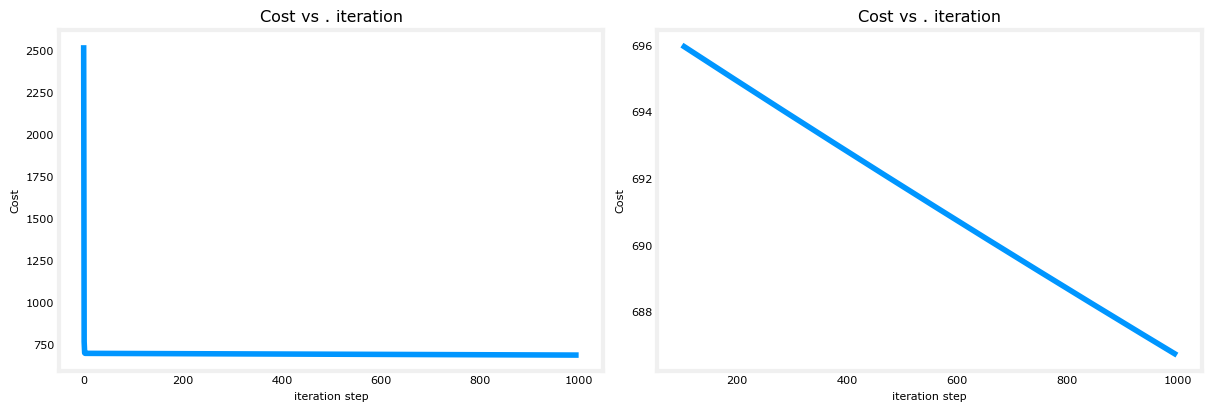

In [27]:
# Cost와 iteration을 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs . iteration")
ax2.set_title("Cost vs . iteration")
ax1.set_ylabel('Cost')
ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')
ax2.set_xlabel('iteration step')
plt.show()